# APRENDIZAJE AUTOMÁTICO
# Práctica 1: Regresión
### Autor: Yoldi Vigueras, Jaime
### NIP:   779057
### Fecha: 05-02-2025
---



## Configuración

In [4]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/P1/Datos/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros

Trabajando en Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 0. Visualización de datos

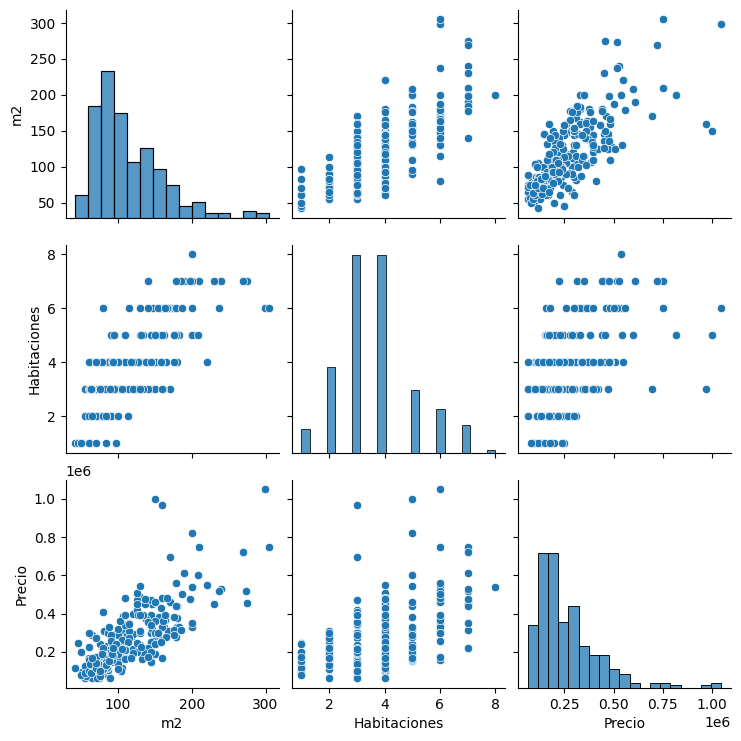

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Leer los ficheros de datos y pasarlos a matrices de numpy
pisos_train = pd.read_csv(Path+'PisosTrain.csv', sep = ";")
x1_train = pisos_train["m2"].to_numpy().reshape(-1, 1)
x2_train = pisos_train["Habitaciones"].to_numpy().reshape(-1, 1)
y_train  = pisos_train["Precio"].to_numpy()

pisos_test  = pd.read_csv(Path+'PisosTest.csv',  sep = ";")
x1_test = pisos_test["m2"].to_numpy().reshape(-1, 1)
x2_test = pisos_test["Habitaciones"].to_numpy().reshape(-1, 1)
y_test  = pisos_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
seaborn.pairplot(pisos_train)
plt.show()

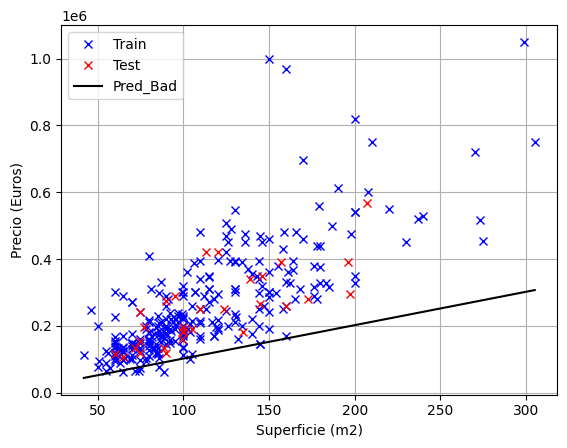

In [ ]:
# Ejemplo de dibujo de un atributo y una prediccion inventada
x1_grid = np.linspace(np.min(x1_train), np.max(x1_train), 100).reshape(-1, 1)
y_grid_pred = x1_grid *1000 + 2000  # Prediccion inventada

plt.figure()
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test,  'rx', label='Test')
plt.plot(x1_grid, y_grid_pred, 'k-', label='Pred_Bad')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()
plt.show()


Aquí explico las conclusiones que he sacado analizando los datos.

---
## 1. Métricas

Las metricas que se van a utilizar para evaluar los modelos van a ser el error cuadratico medio (MSE) y el coeficiente de terminacion R² (R-square).  Ambas medidas son utilizadas para la evaluacion de modelos y conocer como se comportan los predictores con los datos.Estas tienen una funcion de sklearn que permite calcularlas facilmente.

In [8]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

def obtenerMetricas(predictor, x_test, y_test, verbose = True):
  y_pred = predictor.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  if verbose:
    print(f"Error Cuadrático Medio (MSE): {mse}")
    print(f"R-cuadrado (R²): {r2}")
    print(f"Raiz del MSE :  {np.sqrt(mse)}")
    print(f"Error Absoluto Medio (MAE): {mae}")
  return mse, r2, mae

Ademas de la funcion metricas se han diseñado con ayuda de Gemini 2 funciones para mostrar graficamente los valores que predice el sistema y como de lejos estan de los datos de test

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualizar2D (predictor, x_test, y_test):
  y_pred = predictor.predict(x_test)
  plt.figure()
  plt.plot(x1_test, y_test, 'rx', label='Test')
  plt.plot(x1_test, y_pred, 'k-', label='Predicciones')
  plt.xlabel('Superficie (m2)')
  plt.ylabel('Precio (Euros)')
  plt.legend()
  plt.grid()
  plt.show()


#se muestra un plano con los valores predichos para todo el rango de valores y puntos
#donde se encuentran los valores reales unidos al plano por el punto que indica el valor predicho
def visualizar3D (predictor, x_test, y_test):
  # Crear la figura y el objeto Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Obtener los valores mínimos y máximos de x1 y x2 de los datos de prueba
  x1_min = np.min(x_test[:, 0])  # Columna 0 de x_test (m2)
  x1_max = np.max(x_test[:, 0])
  x2_min = np.min(x_test[:, 1])  # Columna 1 de x_test (Habitaciones)
  x2_max = np.max(x_test[:, 1])

  # Crear una malla para el plano de predicciones
  x1_range = np.arange(x1_min, x1_max, 10)  # Ajusta el paso según sea necesario
  x2_range = np.arange(x2_min, x2_max, 1)   # Ajusta el paso según sea necesario
  x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

  # Predecir valores para la malla
  x_grid = np.stack([x1_grid.ravel(), x2_grid.ravel()], axis=1)
  y_grid_pred = predictor.predict(x_grid)
  y_grid_pred = y_grid_pred.reshape(x1_grid.shape)  # Redimensionar para coincidir con la malla

  # Graficar el plano de predicciones
  ax.plot_surface(x1_grid, x2_grid, y_grid_pred, alpha=0.5)  # alpha controla la transparencia

  # Predecir valores para los puntos de prueba
  y_pred = predictor.predict(x_test)

  # Crear una máscara para los puntos con precio menor que el predicho
  mask_lower = y_test < y_pred

  # Graficar los puntos de datos reales, separando por color
  ax.scatter(x_test[mask_lower, 0], x_test[mask_lower, 1], y_test[mask_lower], color='yellow', marker='o', label='Precio menor que predicho')
  ax.scatter(x_test[~mask_lower, 0], x_test[~mask_lower, 1], y_test[~mask_lower], color='red', marker='o', label='Precio mayor o igual que predicho')

   # Dibujar líneas entre los puntos reales y los predichos
  for i in range(len(x_test)):
    ax.plot([x_test[i, 0], x_test[i, 0]], [x_test[i, 1], x_test[i, 1]], [y_test[i], y_pred[i]], color='gray', linestyle='--', alpha=0.5)

   # Dibujar 'x' en los puntos predichos en el plano
  ax.scatter(x_test[:, 0], x_test[:, 1], y_pred, marker='x', color='black', s=40, label='Predicciones')  # Ajusta el color y el tamaño según sea necesario


  # Ajustes del gráfico
  ax.set_xlabel('Superficie (m2)')
  ax.set_ylabel('Habitaciones')
  ax.set_zlabel('Precio (Euros)')
  ax.legend()
  plt.show()
  ax.view_init(elev=30, azim=45)
  plt.show()
  ax.view_init(elev=45, azim=30)
  plt.show()


----
## 2. Regresión Monovariable

Si hace falta, explico cómo lo he resuelto y por qué, y **cito todas las fuentes utilizadas**.

Error Cuadrático Medio (MSE): 6500962224.887705
R-cuadrado (R²): 0.4608909883530128
Raiz del MSE :  80628.54472758209
Error Absoluto Medio (MAE): 63936.47453907921
Ecuación de la regresión: y = 2608.21x + -34313.39


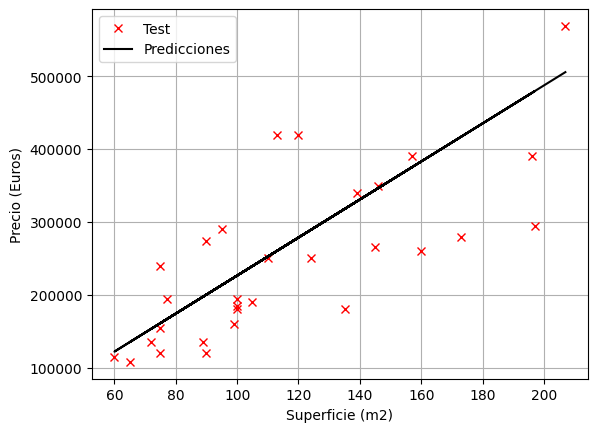

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(x1_train, y_train)

# Calculo las metricas
obtenerMetricas(modelo, x1_test, y_test)  # Asumiendo que ya tienes la función obtenerMetricas

# muestro la ecuacion que se usa para predecir
m = modelo.coef_[0]  # Pendiente
b = modelo.intercept_  # Intersección

print(f"Ecuación de la regresión: y = {m:.2f}x + {b:.2f}")

visualizar2D(modelo, x1_test, y_test)


Aquí explico y analizo los resultados obtenidos.

----

## 3. Regresión Multivariable Simple


Error Cuadrático Medio (MSE): 5586146700.128626
R-cuadrado (R²): 0.5367544184625004
Raiz del MSE :  74740.52916676886
Error Absoluto Medio (MAE): 55256.44082483397
Ecuación de la regresión: y = 3028.74x + -18852.83 + -12132.91


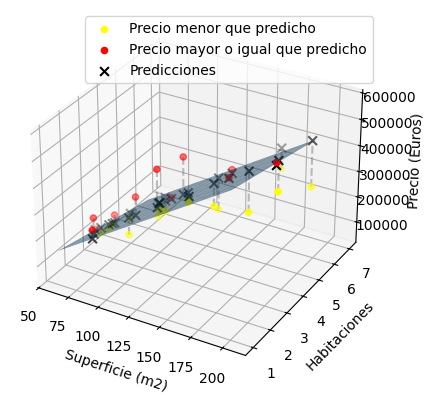

In [28]:
from sklearn.linear_model import LinearRegression
import numpy as np

#combinamos los datos
X_train = np.concatenate((x1_train, x2_train), axis=1)
X_test = np.concatenate((x1_test, x2_test), axis=1)
# Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Calculo las metricas
obtenerMetricas(modelo, X_test, y_test)  # Asumiendo que ya tienes la función obtenerMetricas

# muestro la ecuacion que se usa para predecir
m1 = modelo.coef_[0]  # Pendiente 1
m2 = modelo.coef_[1]  # Pendiente 2
b = modelo.intercept_  # Intersección

print(f"Ecuación de la regresión: y = {m1:.2f}x + {m2:.2f} + {b:.2f}")

visualizar3D(modelo, X_test, y_test)


----

## 4. Regresión Multivariable Descenso de Gradiente

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

#combinamos los datos
X_train = np.concatenate((x1_train, x2_train), axis=1)
X_test = np.concatenate((x1_test, x2_test), axis=1)
# Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Calculo las metricas
obtenerMetricas(modelo, X_test, y_test)  # Asumiendo que ya tienes la función obtenerMetricas

# muestro la ecuacion que se usa para predecir
m1 = modelo.coef_[0]  # Pendiente 1
m2 = modelo.coef_[1]  # Pendiente 2
b = modelo.intercept_  # Intersección

print(f"Ecuación de la regresión: y = {m1:.2f}x + {m2:.2f} + {b:.2f}")

visualizar3D(modelo, X_test, y_test)

----

## 5. Regresión Robusta Huber

----

## 6. Redes neuronales